<center><img src="https://perceivelab.github.io/knowledge-discovery-course/imgs/logo.jpg" width="300" height="103"></center>
<p align=center>A.A. 2020/2021</p>
<p align=center><b>Cloud Computing Project</b></p>
<p align=center>Ylenia Messina — 1000008815</p>

The aim of this project was to firstly carry out a data analysis on the **New York City Taxi** public dataset — available on the *Google Cloud Platform* — using BigQuery, and then to build a machine learning model using BigQuery ML. 

The task for the machine learning model consisted in a regression problem: the goal was to predict the taxi "fare amount" of a ride, given features such as pick-up and drop-off locations, ride distance, day of week and pick-up hour.

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

# Load BigQuery NYC Taxi Data

In [ ]:
from google.cloud import bigquery

# Create a "Client" object
PROJECT = 'turnkey-chimera-316214'
client = bigquery.Client(project=PROJECT)

The dataset imported is the table "*bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015*". It contains data all the trips by yellow taxicabs in New York City during 2015. 

For simplicity and to avoid any long time computations, only records of January were considered (or at least for descriptive analysis purposes).

In [ ]:
query = """
        SELECT *
        FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
        WHERE EXTRACT(MONTH FROM pickup_datetime) = 1
        """

# Set up the query 
query_job = client.query(query)

# API request - try to run the query, and return a pandas DataFrame
df = query_job.to_dataframe()
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount
0,2,2015-01-22 12:38:09,2015-01-22 12:58:56,1,1.24,-73.969666,40.757858,NaN,N,-73.983826,40.755970,2,13.0,0.0,0.5,0.0,0.0,0.3,13.8
1,2,2015-01-21 06:34:35,2015-01-21 06:43:55,1,1.86,-73.951874,40.766041,NaN,N,-73.976021,40.760300,1,9.0,0.0,0.5,1.2,0.0,0.3,11.0
2,1,2015-01-29 20:42:49,2015-01-29 20:42:49,3,0.00,-73.974876,40.759731,NaN,N,0.000000,0.000000,2,5.0,0.5,0.5,0.0,0.0,0.3,6.3
3,2,2015-01-26 11:42:57,2015-01-26 11:59:53,2,2.12,-73.982826,40.781746,NaN,N,-73.963036,40.763386,2,12.5,0.0,0.5,0.0,0.0,0.3,13.3
4,2,2015-01-11 01:30:44,2015-01-11 01:41:38,2,3.11,-73.987198,40.744961,NaN,N,-74.006302,40.708031,1,11.0,0.5,0.5,2.3,0.0,0.3,14.6


The dataset is composed of the following 19 features of mixed data type:

*   **vendor_id**: (string) A code indicating the Taxicab Technology Service Provider that provided the record. 1 = Creative Mobile Technologies, LLC; 2 = VeriFone Inc.
*   **pickup_datetime**: (datetime) The date and time when the meter was engaged.
*   **dropoff_datetime**: (datetime) The date and time when the meter was disengaged.
*   **passenger_count**: (integer) The number of passengers in the vehicle. This is a driver-entered value.
*   **trip_distance**: (float) The elapsed trip distance in miles reported by the taximeter.
*   **pickup_longitude**: (float) Longitude where the meter was engaged.
*   **pickup_latitude**: (float) Latitude where the meter was engaged.
*   **rate_code**: (integer) The final rate code in effect at the end of the trip. 1= Standard rate; 2=JFK; 3=Newark; 4=Nassau or Westchester; 5=Negotiated fare; 6=Group ride.
*   **store_and_fwd_flag**: (string) This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server. Y= store and forward trip N= not a store and forward trip.
*   **dropoff_longitude**: (float) Longitude where the meter was disengaged.
*   **dropoff_latitude**: (float) Latitude where the meter was disengaged.
*   **payment_type**: (string) A numeric code signifying how the passenger paid for the trip. 1= Credit card; 2= Cash; 3= No charge; 4= Dispute; 5= Unknown; 6= Voided trip.
*   **fare_amount**: (float) The time-and-distance fare calculated by the meter.
*   **extra**: (float) Miscellaneous extras and surcharges. Currently, this only includes the \$0.50 and \$1 rush hour and overnight charges.
*   **mta_tax**: (float) \$0.50 MTA tax that is automatically triggered based on the metered rate in use.
*   **tip_amount**: (float) Tip amount. This field is automatically populated for credit card tips. Cash tips are not included.
*   **tolls_amount**: (float) Total amount of all tolls paid in trip.
*   **imp_surcharge**: (float) \$0.30 improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015.
*   **total_amount**: (float) The total amount charged to passengers. Does not include cash tips.

# Descriptive Analysis

Let's analyze better some variables, in particular:

*  The total fare of the taxi ride, as combination of the variables *tolls_amount* and *fare_amount*.
*  The *pickup_hour*.
*  The *trip_distance*.
*  The *passenger_count*.

The total fare is going to be the target variable to predict in the predictive analysis section, while the other features will be the main predictor variables.

In [ ]:
query = """
        SELECT EXTRACT(HOUR FROM DATETIME_TRUNC(pickup_datetime, hour)) AS pickup_hour,
               EXTRACT(DAYOFWEEK FROM pickup_datetime) AS dayofweek,
               trip_distance,
               passenger_count,
               (tolls_amount + fare_amount) AS total_fare
        FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
        WHERE EXTRACT(MONTH FROM pickup_datetime) = 1
        """

df = client.query(query).to_dataframe()
df

,pickup_hour,dayofweek,trip_distance,passenger_count,total_fare
0,0,2,2.00,1,8.0
1,0,5,1.30,5,7.5
2,0,3,3.00,1,11.0
3,0,2,8.50,3,26.5
4,0,7,4.24,1,20.5
...,...,...,...,...,...
12748981,23,1,1.91,1,8.0
12748982,23,6,1.78,2,7.5
12748983,23,5,0.92,1,5.0
12748984,23,4,4.50,1,16.5


In [ ]:
# Summary info
df.describe()

,pickup_hour,dayofweek,trip_distance,passenger_count,total_fare
count,1.274899e+07,1.274899e+07,1.274899e+07,1.274899e+07,1.274899e+07
mean,1.356740e+01,4.390051e+00,1.345913e+01,1.681491e+00,1.214916e+01
std,6.411436e+00,2.010016e+00,9.844094e+03,1.337924e+00,1.109433e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,-4.500000e+02
25%,9.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,6.500000e+00
50%,1.400000e+01,5.000000e+00,1.680000e+00,1.000000e+00,9.000000e+00
75%,1.900000e+01,6.000000e+00,3.000000e+00,2.000000e+00,1.350000e+01
max,2.300000e+01,7.000000e+00,1.542000e+07,9.000000e+00,4.008000e+03


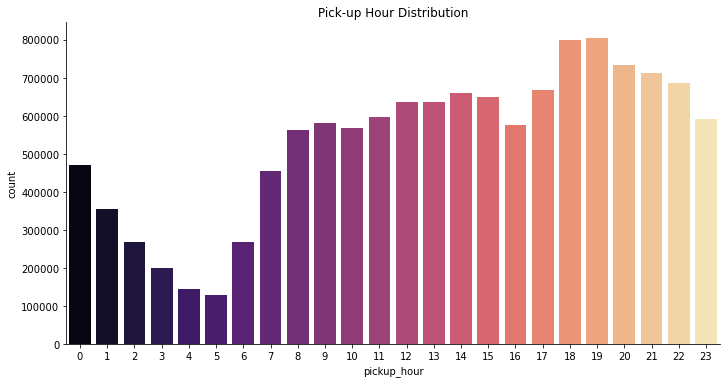

In [ ]:
# 'hour' boxplot
sns.catplot(x="pickup_hour", kind="count", palette="magma", data=df, aspect=2).set(title="Pick-up Hour Distribution");

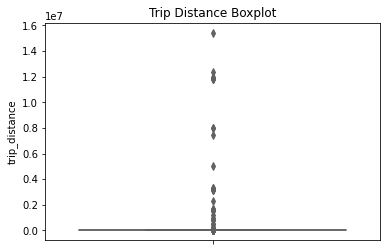

In [ ]:
# 'trip_distance' boxplot
sns.boxplot(y="trip_distance", data=df, palette="PuBu").set(title="Trip Distance Boxplot");

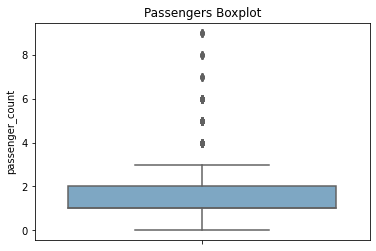

In [ ]:
# 'passenger_count' boxplot
sns.boxplot(y="passenger_count", data=df, palette="PuBu").set(title="Passengers Boxplot");

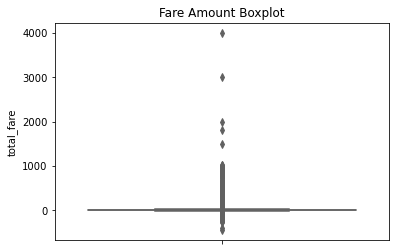

In [ ]:
# 'fare_amount' boxplot
sns.boxplot(y="total_fare", data=df, palette="PuBu").set(title="Fare Amount Boxplot");

In terms of *pickup_hour* distribution, the dataset contains more taxi rides where passengers are picked up in the late afternoon and evening hours. 

With regard to variables *trip_distance*, *passenger_count* and *fare_amount* data are are very noisy: the plots obtained are not so easy to interpret due to the presence of a significant number of outliers.

Therefore data needs to be cleaned removing those outliers, in order to have a better performance in predictive analysis later.

## "Pre-process" data

Therefore data is reduced, performing a query with the following conditions in the WHERE clauses:
*   The number of passengers must be between the range 1 and 4.
*   The ride distance from pick-up to drop-off location can't exceed the limit of 500 miles.
*   Latitude and longitude of both pick-up and drop-off locations are set respectively > 40 and < -73, since latitude and longitude coordinates of New York City are 40.730610, -73.935242.
*   The ride duration must be at least of 5 minutes.
*   The total taxi fare (as summation of the basic fare plus tolls amount) can't exceed $100.

In [ ]:
clean_data_query = """
                  WITH T AS (
                    SELECT
                      *,
                      FORMAT_TIME('%T', TIME(DATETIME_ADD(DATETIME(TIMESTAMP(DATE(1970, 1, 1))), 
                                 INTERVAL DATETIME_DIFF(dropoff_datetime,pickup_datetime,SECOND) SECOND))) 
                                 AS trip_duration,
                      (tolls_amount + fare_amount) AS total_fare,
                    FROM
                      `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
                    WHERE EXTRACT(MONTH FROM pickup_datetime) = 1
                          AND passenger_count > 0 
                          AND passenger_count < 5
                          AND trip_distance > 0 
                          AND trip_distance < 500
                          AND pickup_latitude > 40 AND pickup_longitude < -73
                          AND dropoff_latitude > 40 AND dropoff_longitude < -73
                    )
                  SELECT
                    *
                  FROM T
                  WHERE trip_duration > '00:05:00'
                        AND total_fare > 0 
                        AND total_fare <= 100
                  """     

df = client.query(clean_data_query).to_dataframe()
df

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,trip_duration,total_fare
0,1,2015-01-15 00:47:27,2015-01-15 00:56:35,2,4.70,-73.978241,40.748188,NaN,N,-73.906555,...,2,15.0,0.5,0.5,0.00,5.33,0.3,21.63,00:09:08,20.33
1,2,2015-01-14 14:05:51,2015-01-14 14:38:49,1,9.40,-73.863235,40.769581,NaN,N,-73.975388,...,1,33.5,0.0,0.5,5.00,5.33,0.3,44.63,00:32:58,38.83
2,2,2015-01-18 20:37:03,2015-01-18 21:04:14,1,9.67,-73.954605,40.763985,NaN,N,-73.974709,...,1,29.5,0.5,0.5,6.00,0.00,0.3,36.80,00:27:11,29.50
3,2,2015-01-20 07:42:57,2015-01-20 08:19:10,1,11.52,-73.863892,40.769821,NaN,N,-73.981483,...,1,34.5,0.0,0.5,7.97,5.33,0.3,48.60,00:36:13,39.83
4,1,2015-01-21 23:08:36,2015-01-21 23:55:57,1,10.60,-73.937965,40.797031,NaN,N,-73.940849,...,1,41.5,0.5,0.5,10.00,0.00,0.3,52.80,00:47:21,41.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9364309,1,2015-01-08 22:39:37,2015-01-08 22:56:23,1,6.90,-73.948128,40.829773,NaN,N,-74.003479,...,1,21.5,0.5,0.5,4.00,0.00,0.3,26.80,00:16:46,21.50
9364310,2,2015-01-23 08:50:17,2015-01-23 09:26:58,1,2.08,-73.955139,40.773170,NaN,N,-73.977013,...,2,21.5,0.0,0.5,0.00,0.00,0.3,22.30,00:36:41,21.50
9364311,2,2015-01-11 15:23:31,2015-01-11 15:50:35,1,5.28,-73.991127,40.727692,NaN,N,-73.974152,...,1,21.5,0.0,0.5,3.00,0.00,0.3,25.30,00:27:04,21.50
9364312,1,2015-01-18 22:41:54,2015-01-18 23:05:15,1,6.10,-73.991837,40.739998,NaN,N,-73.926216,...,1,21.5,0.5,0.5,4.00,0.00,0.3,26.80,00:23:21,21.50


In [ ]:
# Summary info
df.describe()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,total_fare
count,9.364314e+06,9.364314e+06,9.364314e+06,9.364314e+06,0.0,9.364314e+06,9.364314e+06,9.364314e+06,9.364314e+06,9.364314e+06,9.364314e+06,9.364314e+06,9.364314e+06,9.364314e+06,9.364314e+06
mean,1.319844e+00,3.210964e+00,-7.397424e+01,4.075013e+01,NaN,-7.397400e+01,4.075093e+01,1.323994e+01,3.096158e-01,4.988166e-01,2.141985e+00,2.837345e-01,2.823261e-01,1.677365e+01,1.352367e+01
std,6.671840e-01,3.563319e+00,4.617394e-02,1.232896e-01,NaN,4.409390e-01,1.856630e-01,9.630127e+00,5.078420e-01,2.429583e-02,1.290995e+03,1.298685e+00,7.063855e-02,1.291050e+03,1.046944e+01
min,1.000000e+00,1.000000e-02,-1.193147e+02,4.004163e+01,NaN,-7.401667e+02,4.004163e+01,-3.000000e-01,-7.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.970000e+01,1.000000e-02
25%,1.000000e+00,1.300000e+00,-7.399210e+01,4.073599e+01,NaN,-7.399143e+01,4.073431e+01,7.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,9.550000e+00,7.500000e+00
50%,1.000000e+00,2.000000e+00,-7.398215e+01,4.075293e+01,NaN,-7.398029e+01,4.075358e+01,1.000000e+01,0.000000e+00,5.000000e-01,1.400000e+00,0.000000e+00,3.000000e-01,1.235000e+01,1.000000e+01
75%,1.000000e+00,3.500000e+00,-7.396845e+01,4.076698e+01,NaN,-7.396377e+01,4.076827e+01,1.500000e+01,5.000000e-01,5.000000e-01,2.360000e+00,0.000000e+00,3.000000e-01,1.780000e+01,1.500000e+01
max,4.000000e+00,4.804000e+02,-7.311555e+01,4.047000e+02,NaN,-6.666700e-02,4.595333e+02,1.000000e+02,6.480200e+02,5.000000e-01,3.950589e+06,8.194000e+01,3.000000e-01,3.950612e+06,1.000000e+02


## Fare Amount vs. "Time" features

### ***What is the average fare amount of a taxi ride by pick-up hour?***

In [ ]:
trip_time_query = """
                  SELECT EXTRACT(HOUR FROM DATETIME_TRUNC(pickup_datetime, hour)) AS pickup_hour,
                         COUNT(1) AS cnt, ROUND(AVG(total_fare),2) as avg_fare_amount, 
                         ROUND(AVG(tip_amount),2) AS avg_tip_amount
                  FROM ({0})
                  GROUP BY pickup_hour
                  ORDER BY pickup_hour
                  """.format(clean_data_query)

time_df = client.query(trip_time_query).to_dataframe()
time_df

,pickup_hour,cnt,avg_fare_amount,avg_tip_amount
0,0,342752,14.43,1.86
1,1,256805,14.23,1.79
2,2,192365,14.20,1.72
3,3,139745,14.95,1.71
4,4,98713,17.29,1.81
5,5,82132,20.01,2.41
6,6,174760,16.08,2.00
7,7,326697,13.63,1.75
8,8,415330,13.02,1.72
9,9,427338,13.00,1.68


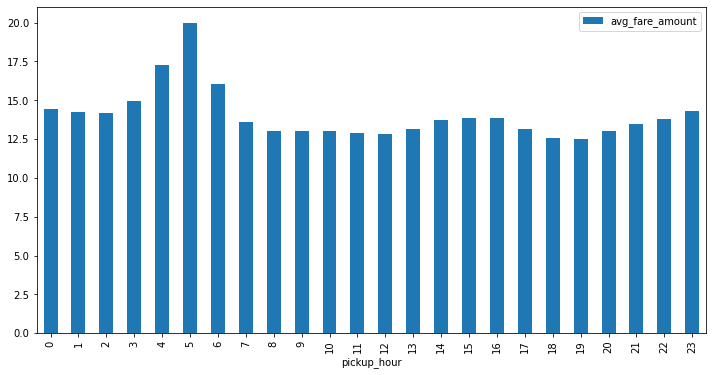

In [ ]:
time_df.plot(kind='bar', x='pickup_hour', y='avg_fare_amount', figsize=(12,6));

### ***What is the average fare amount of a taxi ride by its duration?***

In [ ]:
trip_duration_query = """                     
                      SELECT
                        COUNT(1) AS n_trips,
                        CASE
                          WHEN trip_duration BETWEEN '00:05:00' AND '00:15:00' THEN '< 15min'
                          WHEN trip_duration BETWEEN '00:15:01' AND '00:30:00' THEN '15 - 30min'
                          WHEN trip_duration BETWEEN '00:30:01' AND '01:00:00' THEN '30min - 1h'
                        ELSE '> 1h'
                        END
                        AS duration,
                        ROUND(AVG(total_fare),2) AS avg_fare_amount,
                        ROUND(AVG(tip_amount),2) AS avg_tip_amount
                      FROM ({0})
                      GROUP BY duration
                      ORDER BY
                        CASE
                          WHEN duration = '< 15min' THEN 1
                          WHEN duration = '15 - 30min' THEN 2
                          WHEN duration = '30min - 1h' THEN 3
                          ELSE 4
                        END,
                        duration
                      """.format(clean_data_query)

duration_df = client.query(trip_duration_query).to_dataframe()
duration_df

,n_trips,duration,avg_fare_amount,avg_tip_amount
0,6252821,< 15min,8.80,1.14
1,2574704,15 - 30min,19.32,3.98
2,496357,30min - 1h,40.37,4.98
3,40432,> 1h,44.79,5.06


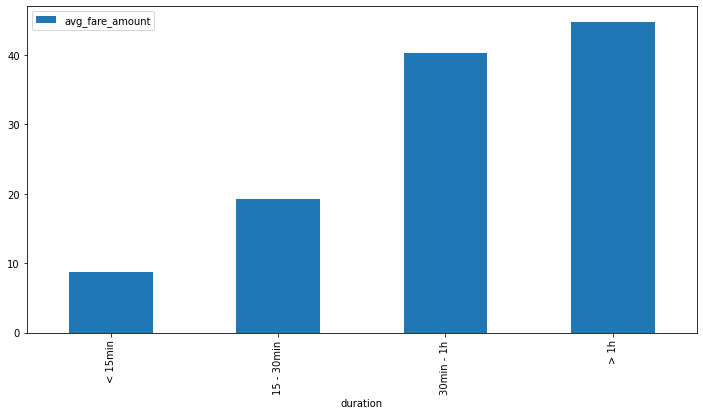

In [ ]:
duration_df.plot(kind='bar', x='duration', y='avg_fare_amount', figsize=(12,6));

## Fare Amount vs. "Spatial" features

### ***What is the average fare amount of a taxi ride by pick-up location?***

In [ ]:
zipcode_query = """
                SELECT
                  zip_code,
                  COUNT(1) AS n_trips,
                  ROUND(AVG(total_fare),2) AS avg_fare_amount,
                  ROUND(AVG(tip_amount),2) AS avg_tip_amount
                 FROM ((SELECT *
                        FROM ({0})
                        WHERE pickup_latitude >= -90 
                              AND pickup_latitude <= 90)
                        JOIN (SELECT
                                zip_code,
                                state_code,
                                state_name,
                                city,
                                county,
                                zip_code_geom
                              FROM
                                `bigquery-public-data.geo_us_boundaries.zip_codes`
                              WHERE
                                city = 'New York city')
                        ON ST_CONTAINS(zip_code_geom, ST_GEOGPOINT(pickup_longitude, pickup_latitude)
                        )
                       )
                GROUP BY zip_code
                """.format(clean_data_query)

zipcode_df = client.query(zipcode_query).to_dataframe()
zipcode_df

,zip_code,n_trips,avg_fare_amount,avg_tip_amount
0,11420,168,31.07,4.42
1,10007,68311,14.13,1.80
2,10026,19772,12.63,1.43
3,10152,8990,11.90,1.93
4,10464,5,16.60,18.60
...,...,...,...,...
200,10470,27,14.33,0.74
201,10305,15,27.63,3.67
202,10001,474249,11.87,1.48
203,11416,43,19.86,1.41


### ***What is the average fare amount of a taxi ride by distance?***

In [ ]:
trip_dist_query = """
                  SELECT
                    COUNT(1) as n_trips,
                    CASE
                      WHEN trip_distance <= 1 THEN '< 1'
                      WHEN trip_distance BETWEEN 1 AND 20 THEN '1 - 20'
                      WHEN trip_distance BETWEEN 20 AND 50 THEN '20 - 50'
                      ELSE '> 500'
                    END
                    AS distance,
                    ROUND(AVG(total_fare),2) AS avg_fare_amount,
                    ROUND(AVG(tip_amount),2) AS avg_tip_amount
                  FROM ({0})
                  GROUP BY distance
                  ORDER BY 
                    CASE
                      WHEN distance = '< 1' THEN 1
                      WHEN distance = '1 - 20' THEN 2
                      WHEN distance = '20 - 50' THEN 3
                      ELSE 4
                    END,
                    distance
                  """.format(clean_data_query)

dist_df = client.query(trip_dist_query).to_dataframe()
dist_df

,n_trips,distance,avg_fare_amount,avg_tip_amount
0,1314817,< 1,6.46,0.82
1,8006627,1 - 20,14.43,2.33
2,42654,20 - 50,60.65,7.05
3,216,> 500,20.46,7.47


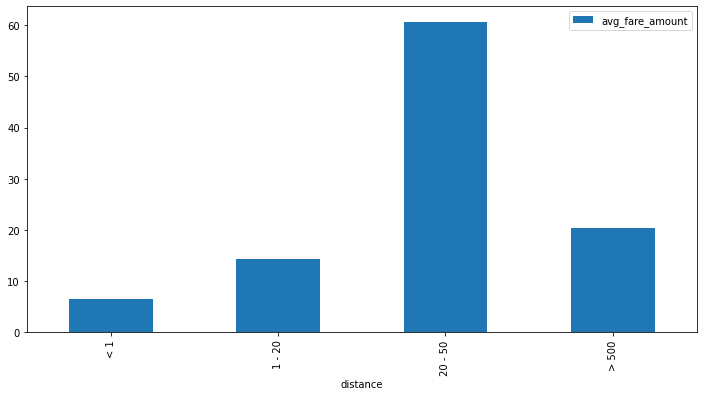

In [ ]:
dist_df.plot(kind='bar', x='distance', y='avg_fare_amount', figsize=(12,6));

# Predictive Analysis

Finally, in this section a predictive analysis is perfomed, using BigQuery ML.

Firstly a function to create the input dataset for the machine learning model is defined. Such function, *create_input_dataset()*, allows to obtain a training, evaluation or test set, with a sampling clause that picks up only a subset of the original full dataset (by default it samples 1000 observations).

The query inside the function maintains the same WHERE conditions mentioned before, however now all data for the year 2015 are considered, not just the month of January.

In [ ]:
def create_input_dataset(split, sample=1000):
  """
  split is TRAIN or EVAL
  sample=1000 pulls 1/1000 of full dataset
  """
  
  query="""
  WITH params AS (
    SELECT
    1 AS TRAIN,
    2 AS EVAL,
    3 AS TEST
    ),

  daynames AS
    (SELECT ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat'] AS daysofweek),

  taxitrips AS (
  SELECT
     *,
    (tolls_amount + fare_amount) AS total_fare
  FROM
    `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`, daynames, params
  WHERE
    trip_distance > 0
    AND trip_distance < 500
    AND passenger_count > 0
    AND passenger_count < 5
    AND pickup_latitude > 40 AND pickup_longitude < -73
    AND dropoff_latitude > 40 AND pickup_longitude < -73
    AND ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), {0})) = params.{1}
  )
  SELECT 
    total_fare,
    daysofweek[ORDINAL(EXTRACT(DAYOFWEEK FROM pickup_datetime))] AS dayofweek,
    EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
    pickup_latitude,
    pickup_longitude,
    dropoff_latitude,
    dropoff_longitude,
    trip_distance,
    passenger_count
  FROM taxitrips
  WHERE total_fare > 0 AND total_fare <= 100
  """.format(sample, split)
  
  return query

In [ ]:
query = create_input_dataset('TRAIN')
trips = client.query(query + " LIMIT 1000", project=PROJECT).to_dataframe()
trips.head()

,total_fare,dayofweek,hourofday,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_distance,passenger_count
0,6.50,Tues,19,40.737301,-74.000824,40.729237,-73.998947,0.71,1
1,18.50,Thurs,11,40.765888,-73.954674,40.731651,-73.992302,4.08,1
2,5.50,Tues,20,40.741978,-74.003807,40.750023,-73.995140,0.85,1
3,57.54,Fri,15,40.641602,-73.787399,40.747753,-73.976784,17.03,1
4,4.00,Sun,12,40.747810,-73.978821,40.752205,-73.975647,0.50,2


In [ ]:
trips.describe()

,total_fare,hourofday,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_distance,passenger_count
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,13.266220,13.622000,40.751132,-73.973613,40.751936,-73.972758,3.065160,1.311000
std,10.811788,6.510261,0.027092,0.038282,0.033120,0.034926,3.528992,0.660845
min,2.500000,0.000000,40.641602,-74.036232,40.616734,-74.181648,0.030000,1.000000
25%,6.500000,9.000000,40.738265,-73.991564,40.734768,-73.991806,1.077500,1.000000
50%,9.750000,14.000000,40.753960,-73.981785,40.754011,-73.980179,1.800000,1.000000
75%,15.000000,19.000000,40.767883,-73.968004,40.770488,-73.961571,3.500000,1.000000
max,82.650000,23.000000,40.813313,-73.776688,40.910728,-73.769989,21.200000,4.000000


Then, the machine learning model to train data is built. The ML model is set a linear regressione model, since the problem involves the prediction of a continuous variable which is the *total_fare* (specified as label in the query).
The value specified for the optional parameter *min_rel_progress*, asks the model training to stop when the improvement is < 0.5%.

In [ ]:
# Create ML model training query
def create_train_query(dataset_query, model_name):
  query="""
        CREATE or REPLACE MODEL {0}
        OPTIONS
          (model_type='linear_reg', labels=['total_fare'], min_rel_progress=0.005) AS
  
        {1}
  
        """.format(model_name, dataset_query)
  return query

In [ ]:
train_query = create_train_query(create_input_dataset('TRAIN'), 'models.taxifare_model')
print(train_query)


        CREATE or REPLACE MODEL models.taxifare_model
        OPTIONS
          (model_type='linear_reg', labels=['total_fare'], min_rel_progress=0.005) AS
  
        
  WITH params AS (
    SELECT
    1 AS TRAIN,
    2 AS EVAL,
    3 AS TEST
    ),

  daynames AS
    (SELECT ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat'] AS daysofweek),

  taxitrips AS (
  SELECT
     *,
    (tolls_amount + fare_amount) AS total_fare
  FROM
    `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`, daynames, params
  WHERE
    trip_distance > 0
    AND trip_distance < 500
    AND passenger_count > 0
    AND passenger_count < 5
    AND pickup_latitude > 40 AND pickup_longitude < -73
    AND dropoff_latitude > 40 AND pickup_longitude < -73
    AND ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), 1000)) = params.TRAIN
  )
  SELECT 
    total_fare,
    daysofweek[ORDINAL(EXTRACT(DAYOFWEEK FROM pickup_datetime))] AS dayofweek,
    EXTRACT(HOUR FROM pickup_datetime) AS hourofday,

## Train the ML model

In [ ]:
client.query(train_query, project=PROJECT).result()

In [ ]:
# Training Loss
def show_training_loss(model_name):
  query = "SELECT iteration, loss from ML.TRAINING_INFO(MODEL {})".format(model_name)

  loss_df = client.query(query, project=PROJECT).to_dataframe()
  loss_df['loss'] = np.sqrt(loss_df['loss'])  # mean square error to RMSE

  if len(loss_df) > 1:
    loss_df.plot(x='iteration', y='loss');
  else:
    print(loss_df)

show_training_loss('models.taxifare_model');

   iteration     loss
0          0  3.62699


## Evaluate the model on validation set

In [ ]:
def create_eval_query(dataset_query, model_name):
  query = """
          SELECT 
            *,
            SQRT(mean_squared_error) AS rmse
          FROM 
            ML.EVALUATE(MODEL {0},
            (
            {1}
            ))  
          """.format(model_name, dataset_query)
  return query

eval_query = create_eval_query(create_input_dataset('EVAL'), 'models.taxifare_model' )
print(eval_query)


          SELECT 
            *,
            SQRT(mean_squared_error) AS rmse
          FROM 
            ML.EVALUATE(MODEL models.taxifare_model,
            (
            
  WITH params AS (
    SELECT
    1 AS TRAIN,
    2 AS EVAL,
    3 AS TEST
    ),

  daynames AS
    (SELECT ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat'] AS daysofweek),

  taxitrips AS (
  SELECT
     *,
    (tolls_amount + fare_amount) AS total_fare
  FROM
    `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`, daynames, params
  WHERE
    trip_distance > 0
    AND trip_distance < 500
    AND passenger_count > 0
    AND passenger_count < 5
    AND pickup_latitude > 40 AND pickup_longitude < -73
    AND dropoff_latitude > 40 AND pickup_longitude < -73
    AND ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), 1000)) = params.EVAL
  )
  SELECT 
    total_fare,
    daysofweek[ORDINAL(EXTRACT(DAYOFWEEK FROM pickup_datetime))] AS dayofweek,
    EXTRACT(HOUR FROM pickup_datetime) AS houro

In [ ]:
eval_df = client.query(eval_query, project=PROJECT).to_dataframe()
eval_df

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance,rmse
0,1.893594,20.590971,0.038803,1.354625,0.830356,0.830357,4.537728


## Apply model to make predictions

In [ ]:
def create_pred_query(dataset_query, model_name):
  query = """
          SELECT
            *
          FROM 
            ML.PREDICT(MODEL {0},
            (
            {1}
            ))  
          """.format(model_name, dataset_query)
  return query

pred_query = create_pred_query(create_input_dataset('TEST', sample=600), 'models.taxifare_model' )
print(pred_query)


          SELECT
            *
          FROM 
            ML.PREDICT(MODEL models.taxifare_model,
            (
            
  WITH params AS (
    SELECT
    1 AS TRAIN,
    2 AS EVAL,
    3 AS TEST
    ),

  daynames AS
    (SELECT ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat'] AS daysofweek),

  taxitrips AS (
  SELECT
     *,
    (tolls_amount + fare_amount) AS total_fare
  FROM
    `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`, daynames, params
  WHERE
    trip_distance > 0
    AND trip_distance < 500
    AND passenger_count > 0
    AND passenger_count < 5
    AND pickup_latitude > 40 AND pickup_longitude < -73
    AND dropoff_latitude > 40 AND pickup_longitude < -73
    AND ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), 600)) = params.TEST
  )
  SELECT 
    total_fare,
    daysofweek[ORDINAL(EXTRACT(DAYOFWEEK FROM pickup_datetime))] AS dayofweek,
    EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
    pickup_latitude,
    pickup_longitude,


In [ ]:
pred_res = client.query(pred_query, project=PROJECT)
pred_res_df = pred_res.to_dataframe()
pred_res_df

,predicted_total_fare,total_fare,dayofweek,hourofday,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_distance,passenger_count
0,37.894898,34.0,Tues,0,40.641361,-73.787918,40.763641,-73.873421,12.32,1
1,25.425324,24.0,Mon,0,40.749142,-73.977539,40.686081,-73.938766,7.27,3
2,5.594855,6.5,Sun,0,40.757919,-73.984756,40.764721,-73.983353,0.70,1
3,11.776038,16.5,Sat,0,40.722229,-73.986786,40.716434,-73.955467,2.80,2
4,7.152214,6.0,Fri,0,40.736706,-73.978554,40.745197,-73.980751,0.96,2
...,...,...,...,...,...,...,...,...,...,...
216418,10.783144,11.0,Wed,23,40.702419,-73.987053,40.677158,-73.979973,2.14,1
216419,12.267208,12.0,Thurs,23,40.757320,-73.975822,40.731270,-73.985695,2.46,1
216420,19.544178,19.5,Sat,23,40.742912,-73.984627,40.768021,-73.925484,5.40,1
216421,15.183861,14.5,Thurs,23,40.755890,-73.990982,40.781670,-73.949333,3.60,1


In [ ]:
# RMSE Loss on test set
actual_values = pred_res_df.total_fare
predicted_values = pred_res_df.predicted_total_fare
rmse = round((mean_squared_error(actual_values, predicted_values) ** .5),2)
print("The rmse loss on test set is: {0}".format(rmse))

The rmse loss on test set is: 3.6


The RMSE Loss on training, validation and test set are similar, suggesting the linear regression model built didn't overfit data.